<a href="https://colab.research.google.com/github/Loop3D/2022_iamg_workshop/blob/main/m2l_wa_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies
This workshop will use three libraries from the Loop project
1. LoopStructural - https://github.com/Loop3D/LoopStructural
2. map2loop - https://github.com/Loop3D/map2loop-2
3. LoopFlow - https://github.com/Loop3D/LoopFlow

The following code blocks will install the required dependencies for the Loop libraries into this colab environment. Alternatively, the workshop can be run using the docker image.

### Introduction
Graph representations of geological maps and 3D models provide a novel approach to understanding pathways in complex geometries. In this study we explore a graph-based methodology for analysing geological topology that permit a range of 2D and 3D non-Euclidean distance metrics to be explored, which are being applied to mineral prospectivity mapping in 2D and flow analysis in 3D. These types of analyses are also used to help you chose the best route to go home.
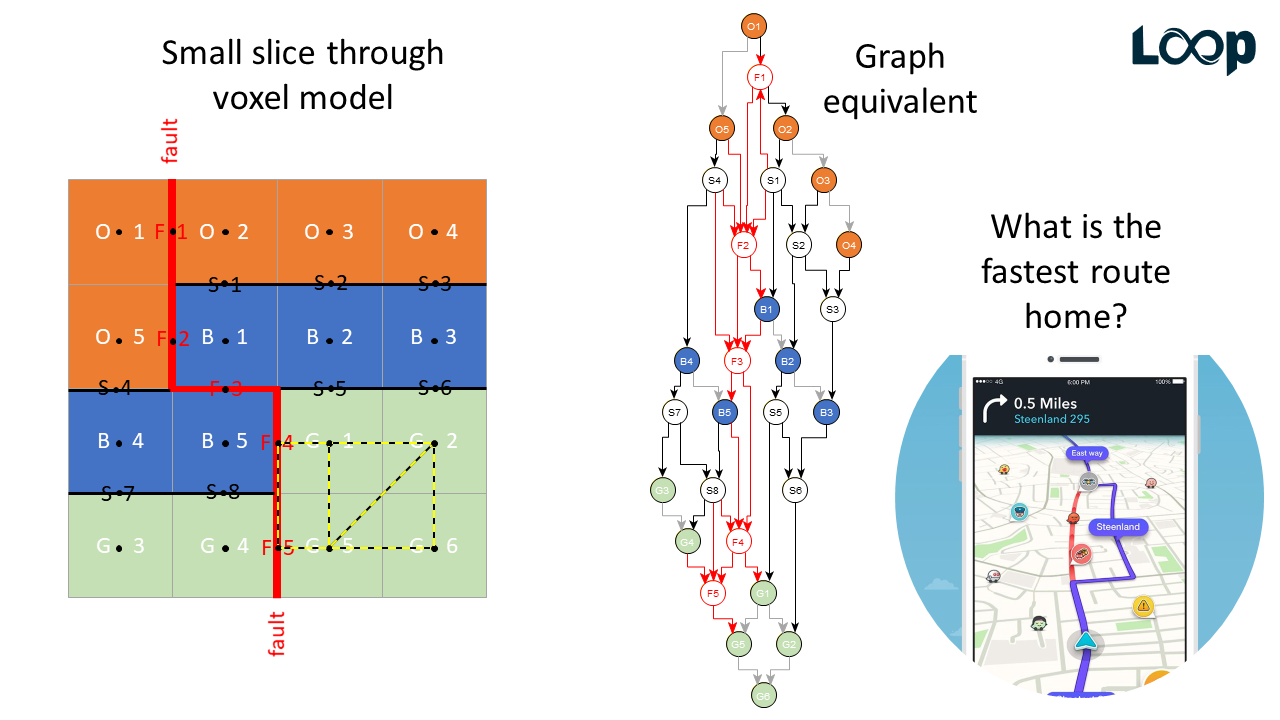

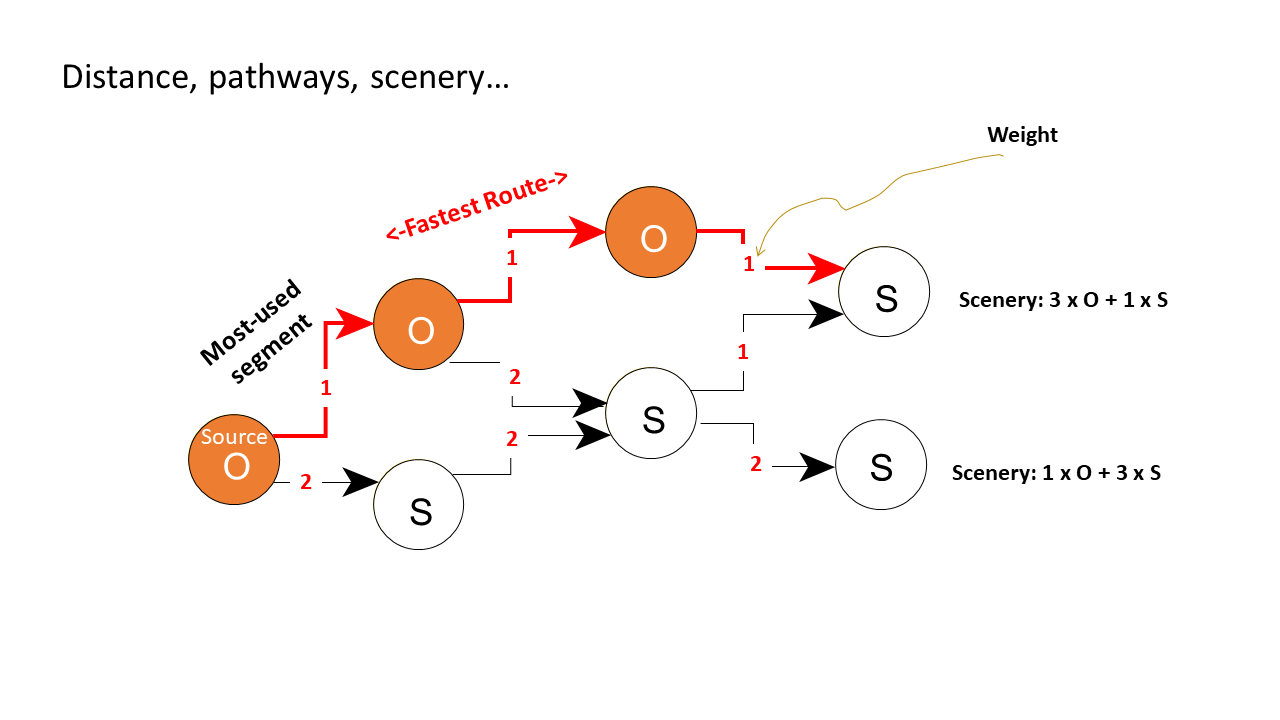

## map2loop + LoopStructural

In [ ]:
!pip install rasterio
!pip install git+https://github.com/geopandas/geopandas.git@v0.10.2
!pip install hjson
!pip install owslib
!pip install git+https://github.com/Loop3D/map2model_cpp.git
!pip install git+https://github.com/Loop3D/LoopProjectFile.git
!pip install pygeos
!pip install mplstereonet
!pip install lavavu-osmesa
!pip install LoopStructural
!pip install git+https://github.com/Loop3D/map2loop-2.git
!pip install beartype
!pip install ipyvolume
!pip install git+https://github.com/Loop3D/LoopFlow.git

In [ ]:
from LoopFlow import __version__
__version__

In [ ]:
bbox_3d = {
     'minx': 480348,
     'miny': 7503794,
     'maxx': 530804,
     'maxy': 7546747,
     'base': -4800,
     'top': 1200}

In [ ]:
import os
import hjson
from map2loop.m2l_enums import VerboseLevel
from map2loop.project import Project
from math import sqrt
import random

out_dir=str(random.randint(1,10000))

proj = Project( 
                 loopdata_state = "WA",
            project_path=out_dir,
    project_crs='EPSG:28350',
    verbose_level=VerboseLevel.NONE,
    working_projection='EPSG:28350',
                )

proj.update_config(
                    out_dir=out_dir,
                    bbox_3d=bbox_3d,
                    project_crs='EPSG:28350',
                    # overwrite='true',
                    # run_flags={'fault_dip':-999},
                    # quiet='None',
    
#                     loopFilename='test.loop3d'
                  )


In [ ]:
proj.run()

In [ ]:
minx,miny,maxx,maxy = proj.config.bbox
model_base = proj.config.bbox_3d['base']
model_top = proj.config.bbox_3d['top']

In [ ]:
f=open(proj.config.tmp_path+'/bbox.csv','w')
f.write('minx,miny,maxx,maxy,lower,upper\n')
ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
f.write(ostr)
f.close()

In [ ]:
from LoopStructural import GeologicalModel
fault_params = {'interpolatortype':'FDI',
                'nelements':1e4,
                'step':10,
                'fault_buffer':0.2,

               }
foliation_params = {'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
                    'nelements':5e4,  # how many tetras/voxels
                    'buffer':2.,  # how much to extend nterpolation around box
                   }


model, m2l_data = GeologicalModel.from_map2loop_directory(proj.config.project_path,
                                                              evaluate=False,
                                                          fault_params=fault_params,
                                                          rescale=False,
#                                                           vectorscale=1,
                                                          foliation_params=foliation_params)

In [ ]:
model.update()

In [ ]:
from LoopStructural.visualisation import LavaVuModelViewer

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()
view = LavaVuModelViewer(model)
view.add_model_surfaces()
view.interactive()

In [ ]:
view.display()

##Code to calculate voxel-level spatial relationship graph and flow proxies

In [ ]:
from LoopFlow import import_triangulation as it
from LoopFlow import calculate_flow as cf



bbox=it.create_bbox(minx,miny,maxx,maxy,model_base,model_top)
destination=out_dir

In [ ]:
voxel_size=750


Graw,df_nodes_raw,df_edges_raw,lengths=cf.graph_from_model(model,voxel_size,bbox,destination)


##Assign weights according to feature (fault, strat contact, interior of unit etc.) and specific fast stratigraphic units

In [ ]:
for f in model.stratigraphic_column:
  if('faults' not in f):
    for s in model.stratigraphic_column[f]:
      print(model.stratigraphic_column[f][s]['id'],s)

In [ ]:
faults_only=False
                    
scenario={     #free-form scenario   
        'fault_node':5.0,
        'geological_formation_slow':5.0,
        'geological_formation_fast':1.0,
        'interformation_node':5.0,

        'fault_formation':5.0,
        'same_fault':5.0,
        'fault_fault':5.0,
        'interform_fault':5.0,
        'interform_formation':5.0,
        'interform_interform':5.0,
        'same_interform':5.0,

        'fast_formation_code':['0']
        }
scenario='fast_faults' #pre-defined scenario
                        # fast_faults    
                        # fast_strat_contacts 
                        # fast_both  
                        # fault_barriers_not_paths  
                        # fault_barriers_but_paths_and_fast_strat
                        #homogeneous

source='west' # 'west', 'east','north', 'south', top', 'base', 'deep_line', 'point'
target='no' # 'west', 'east', 'north', 'south', top', 'base', 'deep_line', 'point', 'no'
fast_formation_code=['3']

ptx=(bbox.loc[0].minx+bbox.loc[0].maxx)/2
pty=(bbox.loc[0].miny+bbox.loc[0].maxy)/2
ptz=bbox.loc[0].lower

f=open(destination+'/parameters.txt','w')
f.write('faults_only = {}\nscenario = {}\nsource = {}\nfast_litho = {}\npoint = {},{},{}\n'.format(faults_only,str(scenario),source,fast_formation_code,ptx,pty,ptz))
f.close()

ranges=voxel_size/2
length_scale_max=sqrt(lengths[0]**2+lengths[1]**2+lengths[2]**2)
G,scenario=cf.assign_weights(Graw,scenario,source,target,fast_formation_code,faults_only,bbox,ptx,pty,ptz,ranges,length_scale_max)



In [ ]:
randomise=True
if(randomise):
    G=cf.randomise_weights(G,1,0.2)

In [ ]:
import networkx as nx
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
dist_nodes,distance,path=cf.calculate_dist(G,df_nodes_raw,voxel_size,bbox,source,scenario,destination,[ptx,pty,ptz])
if(len(path)>1):
    path_nodes=cf.calculate_paths(path,df_nodes_raw,source,scenario,destination)

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import ipyvolume as ipv
LoadPath = out_dir




In [ ]:


df_dist=dist_nodes.copy(deep=True)
df_path=path_nodes.copy(deep=True)

df_dist['color']=256*df_dist['dist']/df_dist['dist'].max()
df_dist['color']=df_dist['color'].astype('int')


In [ ]:
x_lim = [df_path.X.min(), df_path.X.values.max()]
y_lim = [df_path.Y.min(), df_path.Y.values.max()]
z_lim = [df_path.Z.min(), df_path.Z.values.max()]
xyz_lim = [np.min([x_lim, y_lim, z_lim]), np.max([x_lim, y_lim, z_lim])]


x_ratio=1.0
y_ratio=(y_lim[1]-y_lim[0])/(x_lim[1]-x_lim[0])
z_ratio=(z_lim[1]-y_lim[0])/(z_lim[1]-x_lim[0])
x_ratio,y_ratio,z_ratio

x_ratio=1.0
y_ratio=(bbox_3d['maxy']-bbox_3d['miny'])/(bbox_3d['maxx']-bbox_3d['minx'])
y_ratio=(bbox_3d['top']-bbox_3d['base'])/(bbox_3d['maxx']-bbox_3d['minx'])
x_ratio,y_ratio,z_ratio

y_range=(bbox_3d['maxy']-bbox_3d['miny'])*y_ratio
z_range=(bbox_3d['top']-bbox_3d['base'])*z_ratio/5

##Display Dijkstra distance from defined source location based on flow weights of specific geological elements

In [ ]:
import matplotlib.cm
from google.colab import output
output.enable_custom_widget_manager()

cmap = plt.get_cmap("gnuplot")
c = df_dist.color
colors = cmap(c)


size = 700
fig = ipv.figure(width=size, height=size)

scatter = ipv.scatter(df_dist.X.values, df_dist.Y.values, df_dist.Z.values, 
                      color=colors, size=2, marker="box" ) # ‘arrow’, ‘box’, ‘diamond’, ‘sphere’, ‘point_2d’,‘square_2d’, ‘triangle_2d’, 

ipv.xlim(x_lim[0], x_lim[1])
ipv.ylim(y_lim[0]-y_range, y_lim[1]+y_range)
ipv.zlim(z_lim[0]-z_range, z_lim[1]+z_range)
ipv.show()

##Display most used pathways from defined source location based on flow weights of specific geological elements

In [ ]:
import matplotlib.cm
from google.colab import output
output.enable_custom_widget_manager()

path_cutoff=200
df_path_cut=df_path[df_path['count']>path_cutoff].copy(deep=True)
df_path_cut['color']=256*(np.log(df_path_cut['count']-path_cutoff))/(np.log(df_path_cut['count'].max()-path_cutoff))
df_path_cut['color']=df_path_cut['color'].astype('int')


cmap = plt.get_cmap("gnuplot")
c = df_path_cut.color
colors = cmap(c)


size = 700
fig = ipv.figure(width=size, height=size)
scatter = ipv.scatter(df_path_cut.X.values, df_path_cut.Y.values, df_path_cut.Z.values, 
                      color=colors, size=1, marker="box") # ‘arrow’, ‘box’, ‘diamond’, ‘sphere’, ‘point_2d’,‘square_2d’, ‘triangle_2d’, 

ipv.xlim(x_lim[0], x_lim[1])
ipv.ylim(y_lim[0]-y_range, y_lim[1]+y_range)
ipv.zlim(z_lim[0]-z_range, z_lim[1]+z_range)

ipv.show()


In [ ]:
view.interactive()

In [ ]:
scenery=cf.calculate_scenery(G,model,df_nodes_raw,path,source,scenario,destination)    


##Display cumulative path length of Marra Mamba Iron Formation traversed by path to each voxel from defined source location based on flow weights of specific geological elements

In [ ]:
scenery['color']=256*(scenery['Marra_Mamba_Iron_Formation']/scenery['Marra_Mamba_Iron_Formation'].max())
scenery['color']=scenery['color'].astype('int')


cmap = plt.get_cmap("gist_ncar")
c = scenery.color
colors = cmap(c)


size = 700
fig = ipv.figure(width=size, height=size)
scatter = ipv.scatter(scenery.X.values, scenery.Y.values, scenery.Z.values, 
                      color=colors, size=1, marker="box") # ‘arrow’, ‘box’, ‘diamond’, ‘sphere’, ‘point_2d’,‘square_2d’, ‘triangle_2d’, 

ipv.xlim(x_lim[0], x_lim[1])
ipv.ylim(y_lim[0]-y_range, y_lim[1]+y_range)
ipv.zlim(z_lim[0]-z_range, z_lim[1]+z_range)

ipv.show()
